<a href="https://colab.research.google.com/github/Dansah2/Udacity_Tutorials/blob/main/Udacity_Transfer_Flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import os
import matplotlib.pyplot as plt
import numpy as np
import glob
import shutil
import logging
import tensorflow_datasets as tfds
from tensorflow.keras import layers
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [ ]:
# load the data
(train_set, val_set), ds_info = tfds.load('tf_flowers',
                                shuffle_files=True,
                                split=['train', 'train[:30%]'],
                                with_info=True,
                                as_supervised=True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
# number of training examples
print(len(train_set))
num_ex = len(train_set)

3670


In [ ]:
num_classes = ds_info.features['label'].num_classes
print(num_classes)

5


In [ ]:
# number of validation examples
len(val_set)

1101

In [ ]:
# print out the labels
class_names = np.array(ds_info.features['label'].names)

In [ ]:
for i, example_image in enumerate(train_set.take(3)):
  print(f"Image: {i+1}, Shape: {example_image[0].shape}")

Image: 1, Shape: (240, 182, 3)
Image: 2, Shape: (266, 320, 3)
Image: 3, Shape: (200, 320, 3)


In [ ]:
# reformat the images
IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = train_set.shuffle(num_ex//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches =val_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [ ]:
# call the partial model from Tensorflow hub (without the final classification layer)

URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))

In [ ]:
# freeze pretrained model so that the training only modifies
# the final classifier layer

feature_extractor.trainable = False

In [ ]:
model = tf.keras.Sequential([
    feature_extractor,
    layers.Dense(5)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

EPOCHS = 6

history = model.fit(
    train_batches,
    epochs=EPOCHS,
    validation_data=validation_batches,
    batch_size=BATCH_SIZE
)

Epoch 1/6
115/115 [==============================] - 11s 74ms/step - loss: 0.1549 - accuracy: 0.9548 - val_loss: 0.1462 - val_accuracy: 0.9646
Epoch 2/6
115/115 [==============================] - 9s 72ms/step - loss: 0.1328 - accuracy: 0.9659 - val_loss: 0.1271 - val_accuracy: 0.9673
Epoch 3/6
115/115 [==============================] - 8s 60ms/step - loss: 0.1177 - accuracy: 0.9708 - val_loss: 0.1115 - val_accuracy: 0.9773
Epoch 4/6
115/115 [==============================] - 9s 69ms/step - loss: 0.1021 - accuracy: 0.9760 - val_loss: 0.0960 - val_accuracy: 0.9764
Epoch 5/6
115/115 [==============================] - 8s 66ms/step - loss: 0.0907 - accuracy: 0.9793 - val_loss: 0.0939 - val_accuracy: 0.9755
Epoch 6/6
115/115 [==============================] - 8s 60ms/step - loss: 0.0814 - accuracy: 0.9826 - val_loss: 0.0812 - val_accuracy: 0.9846


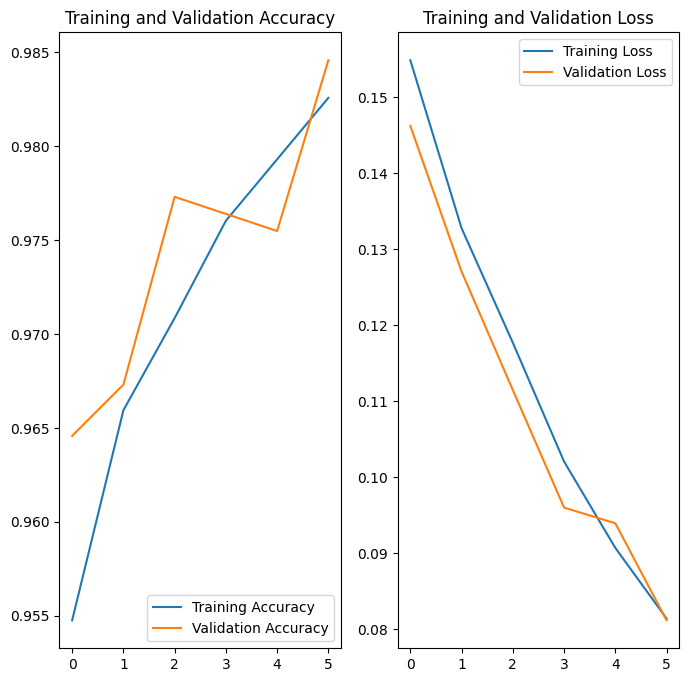

In [ ]:
# Plot training and validation graphs

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(EPOCHS)

plt.figure(figsize=(8,8))

plt.subplot(1,2,1)
plt.plot(epoch_range, acc, label='Training Accuracy')
plt.plot(epoch_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epoch_range, loss, label='Training Loss')
plt.plot(epoch_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
class_names = ds_info.features['label'].names
print(class_names)

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


In [ ]:
# create an image batch and make predictions

image_batch, label_batch = next(iter(train_batches))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

1/1 [==============================] - 0s 31ms/step
['dandelion' 'daisy' 'daisy' 'dandelion' 'sunflowers' 'roses' 'roses'
 'sunflowers' 'daisy' 'sunflowers' 'roses' 'daisy' 'tulips' 'dandelion'
 'daisy' 'roses' 'daisy' 'dandelion' 'roses' 'tulips' 'sunflowers' 'roses'
 'dandelion' 'dandelion' 'tulips' 'sunflowers' 'sunflowers' 'tulips'
 'daisy' 'tulips' 'roses' 'roses']


In [ ]:
print(f"Labels:   {label_batch}")
print(f"P-Labels: {predicted_ids}")

Labels:   [0 1 1 0 3 4 4 3 1 3 4 1 2 0 1 4 1 0 4 2 3 4 0 0 2 3 3 2 1 2 4 4]
P-Labels: [0 1 1 0 3 4 4 3 1 3 4 1 2 0 1 4 1 0 4 2 3 4 0 0 2 3 3 2 1 2 4 4]


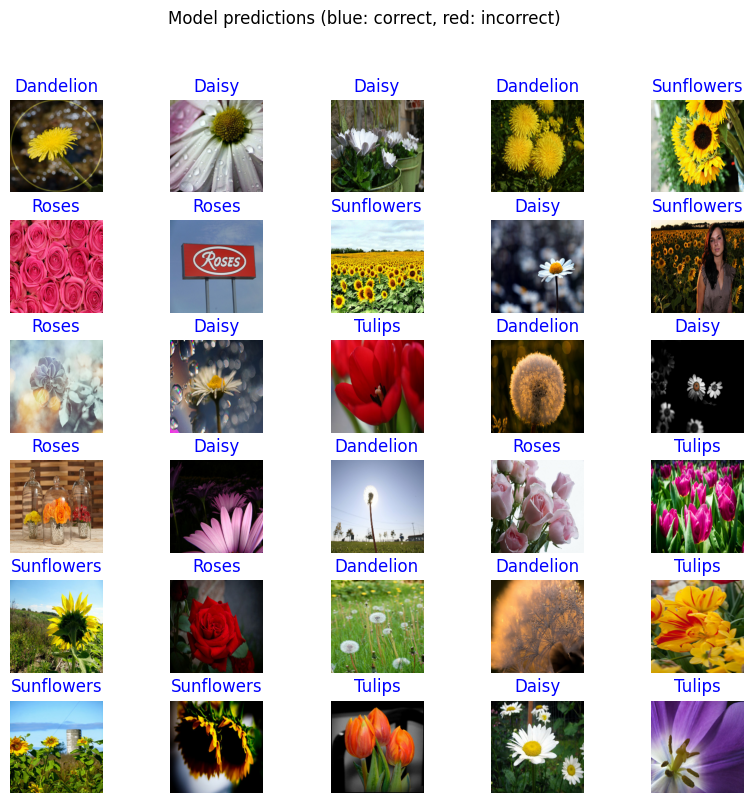

In [ ]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace=0.3)
  plt.imshow(image_batch[n])
  color = 'blue' if predicted_ids[n] == label_batch[n] else 'red'
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
  _ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")